<a href="https://colab.research.google.com/github/ishandahal/stats453-deep_learning_torch/blob/main/GAN/GAN_MLP_(MNIST).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Generative Adversarial Network (GAN)
Implementing a standard GAN using multi-layered perceptron for both the discriminator and generator


Imports

In [1]:
import time 
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn 
from torchvision import datasets
from torchvision import transforms 
from torch.utils.data import DataLoader

torch.backends.cudnn.deterministic = True

### Settings and Dataset

In [7]:
## settings 

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

## hyperparameters
random_seed = 123
generator_learning_rate = 0.001
discriminator_learning_rate = 0.001
num_epochs = 100 
batch_size = 128
LATENT_DIM = 100
IMG_SHAPE = (1, 28, 28)
IMG_SIZE = 1
for x in IMG_SHAPE:
    IMG_SIZE *= x


## MNIST DATASET
train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Model

In [8]:
class GAN(nn.Module):

    def __init__(self):
        super(GAN, self).__init__()

        self.generator = nn.Sequential(
            nn.Linear(LATENT_DIM, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, IMG_SIZE),
            nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            nn.Linear(IMG_SIZE, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def generator_forward(self, z):
        img = self.generator(z)
        return img

    def discriminator_forward(self, img):
        pred = self.discriminator(img)
        return pred.view(-1)

In [13]:
torch.manual_seed(random_seed)

model = GAN()
model = model.to(device)

optim_gener = torch.optim.Adam(model.generator.parameters(), lr=generator_learning_rate)
optim_discr = torch.optim.Adam(model.discriminator.parameters(), lr=discriminator_learning_rate)

### Training

In [14]:
start_time = time.time()

discr_costs = []
gener_costs = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        ## Normalize images to [-1, 1] range
        features = (features - 0.5) * 2.  
        features = features.view(-1, IMG_SIZE).to(device)
        targets = targets.to(device)

        valid = torch.ones(targets.size(0)).float().to(device)
        fake = torch.zeros(targets.size(0)).float().to(device)

        ####
        # Train Generator
        ####

        # Make new images 
        z = torch.zeros((targets.size(0), LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
        generated_features = model.generator_forward(z)

        # Loss for fooling the discriminator 
        discr_pred = model.discriminator_forward(generated_features)

        gener_loss = F.binary_cross_entropy(discr_pred, valid)

        optim_gener.zero_grad()
        gener_loss.backward()
        optim_gener.step()

        ###
        # Train Discriminator
        ###

        discr_pred_real = model.discriminator_forward(features.view(-1, IMG_SIZE))
        real_loss = F.binary_cross_entropy(discr_pred_real, valid)

        discr_pred_fake = model.discriminator_forward(generated_features.detach())
        fake_loss = F.binary_cross_entropy(discr_pred_fake, fake)

        discr_loss = 0.5*(real_loss + fake_loss)

        optim_discr.zero_grad()
        discr_loss.backward()
        optim_discr.step()

        discr_costs.append(discr_loss.item())
        gener_costs.append(gener_loss.item())

        ## Logging 
        if not batch_idx % 100:
            print(f"Epoch: {epoch+1:03d}/{num_epochs:03d} | Batch {batch_idx:03d}/{len(train_loader):03d} | "
                  f"Gen/Dis Loss {gener_loss:.4f}/{discr_loss:.4f}")

    print(f"Time elapsed: {(time.time() - start_time)/60:.2f} min")         

print(f"Total time elapsed: {(time.time() - start_time)/60:.2f} min") 

Epoch: 001/100 | Batch 000/469 | Gen/Dis Loss 0.6821/0.7102
Epoch: 001/100 | Batch 100/469 | Gen/Dis Loss 4.3656/0.0455
Epoch: 001/100 | Batch 200/469 | Gen/Dis Loss 1.4268/0.1459
Epoch: 001/100 | Batch 300/469 | Gen/Dis Loss 1.7206/0.1577
Epoch: 001/100 | Batch 400/469 | Gen/Dis Loss 2.2282/0.1306
Time elapsed: 0.10 min
Epoch: 002/100 | Batch 000/469 | Gen/Dis Loss 1.2843/0.2705
Epoch: 002/100 | Batch 100/469 | Gen/Dis Loss 0.7821/0.5430
Epoch: 002/100 | Batch 200/469 | Gen/Dis Loss 0.8501/0.4763
Epoch: 002/100 | Batch 300/469 | Gen/Dis Loss 0.6614/0.5287
Epoch: 002/100 | Batch 400/469 | Gen/Dis Loss 1.4604/0.3189
Time elapsed: 0.19 min
Epoch: 003/100 | Batch 000/469 | Gen/Dis Loss 0.9164/0.4601
Epoch: 003/100 | Batch 100/469 | Gen/Dis Loss 1.1258/0.3913
Epoch: 003/100 | Batch 200/469 | Gen/Dis Loss 1.7097/0.2993
Epoch: 003/100 | Batch 300/469 | Gen/Dis Loss 0.9697/0.4669
Epoch: 003/100 | Batch 400/469 | Gen/Dis Loss 1.2395/0.3690
Time elapsed: 0.29 min
Epoch: 004/100 | Batch 000/469 

### Evaluation 

In [15]:
import matplotlib.pyplot as plt

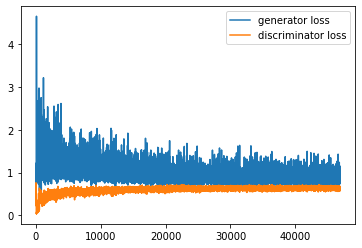

In [18]:
plt.plot(gener_costs, label='generator loss')
plt.plot(discr_costs, label='discriminator loss')
plt.legend()
plt.show()

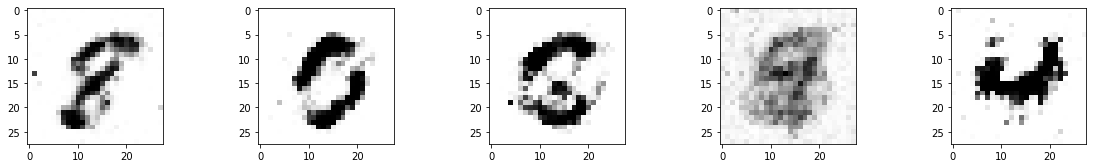

In [20]:
### Visualization

model.eval()
# make new images 

z = torch.zeros((5, LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
generated_features = model.generator_forward(z)
imgs = generated_features.view(-1, 28, 28)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 2.5))

for i, ax in enumerate(axes):
    axes[i].imshow(imgs[i].to(torch.device('cpu')).detach(), cmap='binary')